# PXD014381
## Redox proteome analysis identifies reversible oxidized proteins in retinoic acid differentiated SH-SY5Y cells

[PRIDE link](https://www.ebi.ac.uk/pride/archive/projects/PXD014381)

[Article link](https://pubs.acs.org/doi/10.1021/acs.jproteome.9b00752)

In [1]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)

<module 'OxiAnalysis' from '/home/robbe/ionbot/OxiAnalysis.py'>

In [2]:
first = pd.read_csv("/home/robbe/ionbot/full_projects/PXD014381_first.csv")
del first["Unnamed: 0"]
del first["spectrum_title"]
del first["scan"]
first['modifications'] = first['modifications'].fillna("None")
first['Oxidant treatment'] = first['Oxidant treatment'].fillna("None")
first['Secondary treatment'] = first['Secondary treatment'].fillna("None")
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].fillna(0)
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].replace('0', 0)
first['Length of oxidant treatment (mins)'] = first['Length of oxidant treatment (mins)'].replace('0', 0)

In [3]:
print("The amount of PSMs in this project dataset is: ", first.shape[0])
print("The amount of raw files that make up the master dataset is: ", len(first["spectrum_file"].unique()))

The amount of PSMs in this project dataset is:  165237
The amount of raw files that make up the master dataset is:  15


In [4]:
first['Peptidoform_name'] = first.apply(lambda row: OA.peptidoform_name(row), axis=1)
first['Position'] = first['modifications'].apply(OA.get_positions)
first['Modification'] = first['modifications'].apply(OA.get_modification)
first['Oxidatively_modified'] = first['modifications'].apply(OA.oxidatively_modified)

## Overview of the treatments in this project

In [5]:
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()

,Oxidant treatment,Oxidant dose (µM),Length of oxidant treatment (mins),Secondary treatment,Secondary treatment dose (µM),Length of Secondary treatment (mins),ionbot_match_id
0,Diamide,500,15,None,0,0,74635
1,None,0,0,None,0,0,38526
2,Retinoic acid,10,120,None,0,0,52076


### Conditions that will be compared

| N | Treatment | Treatment 2 | Treatment 3 |
| - | ----------- | ----------- | -------- |
| 1 | Control | Diamide | RA |


In [6]:
Control = first.loc[lambda first: (first["Oxidant treatment"] == "None")]
Diamide = first.loc[lambda first: (first["Oxidant treatment"] == "Diamide")]
RA = first.loc[lambda first: (first["Oxidant treatment"] == "Retinoic acid")]

## Comparison between the treatments

In [7]:
print("There are this many replicates of Control treatment: {}".format(Control["spectrum_file"].nunique()))
print("There are this many replicates of Diamide treatment: {}".format(Diamide["spectrum_file"].nunique()))
print("There are this many replicates of RA treatment: {}".format(RA["spectrum_file"].nunique()))

There are this many replicates of Control treatment: 5
There are this many replicates of Diamide treatment: 5
There are this many replicates of RA treatment: 5


In [8]:
Controlrep = OA.replicate_filter(Control,5)
Diamiderep = OA.replicate_filter(Diamide,5)
RArep = OA.replicate_filter(RA, 5)

In [9]:
print("The ratio of PSMs that contain an oxidative modification in the Control treatment subset: {}".format((Controlrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Diamide treatment subset: {}".format((Diamiderep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the RA treatment subset: {}".format((RArep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the Control treatment subset: 4.035567715458276 %
The ratio of PSMs that contain an oxidative modification in the Diamide treatment subset: 5.745742301737486 %
The ratio of PSMs that contain an oxidative modification in the RA treatment subset: 4.907297159380847 %


In [10]:
mrControlrep = OA.modratios(Controlrep)
mrDiamiderep = OA.modratios(Diamiderep)
mrRArep = OA.modratios(RArep)

In [11]:
modr_temp = pd.merge(mrDiamiderep, mrRArep, on="Modification", suffixes=('_Diamide', '_RA'))
modr = pd.merge(modr_temp, mrControlrep, on="Modification")
modr = modr.rename(columns={'Ratios':'Ratios_Control'})
modr = modr.drop(modr[(modr["Ratios_Diamide"] == 0) | (modr["Ratios_RA"] == 0) | (modr["Ratios_Control"] == 0)].index)
modr

,Modification,Ratios_Diamide,Ratios_RA,Ratios_Control
41,[129]Iodo[Y],0.006461,0.009385,0.012175
74,[421]Sulfide[W],0.003482,0.021318,0.052632
121,[1922]Pro->HAVA[P],0.000051,0.000220,0.000182
129,[35]oxidation[M],0.287479,0.516293,0.311888


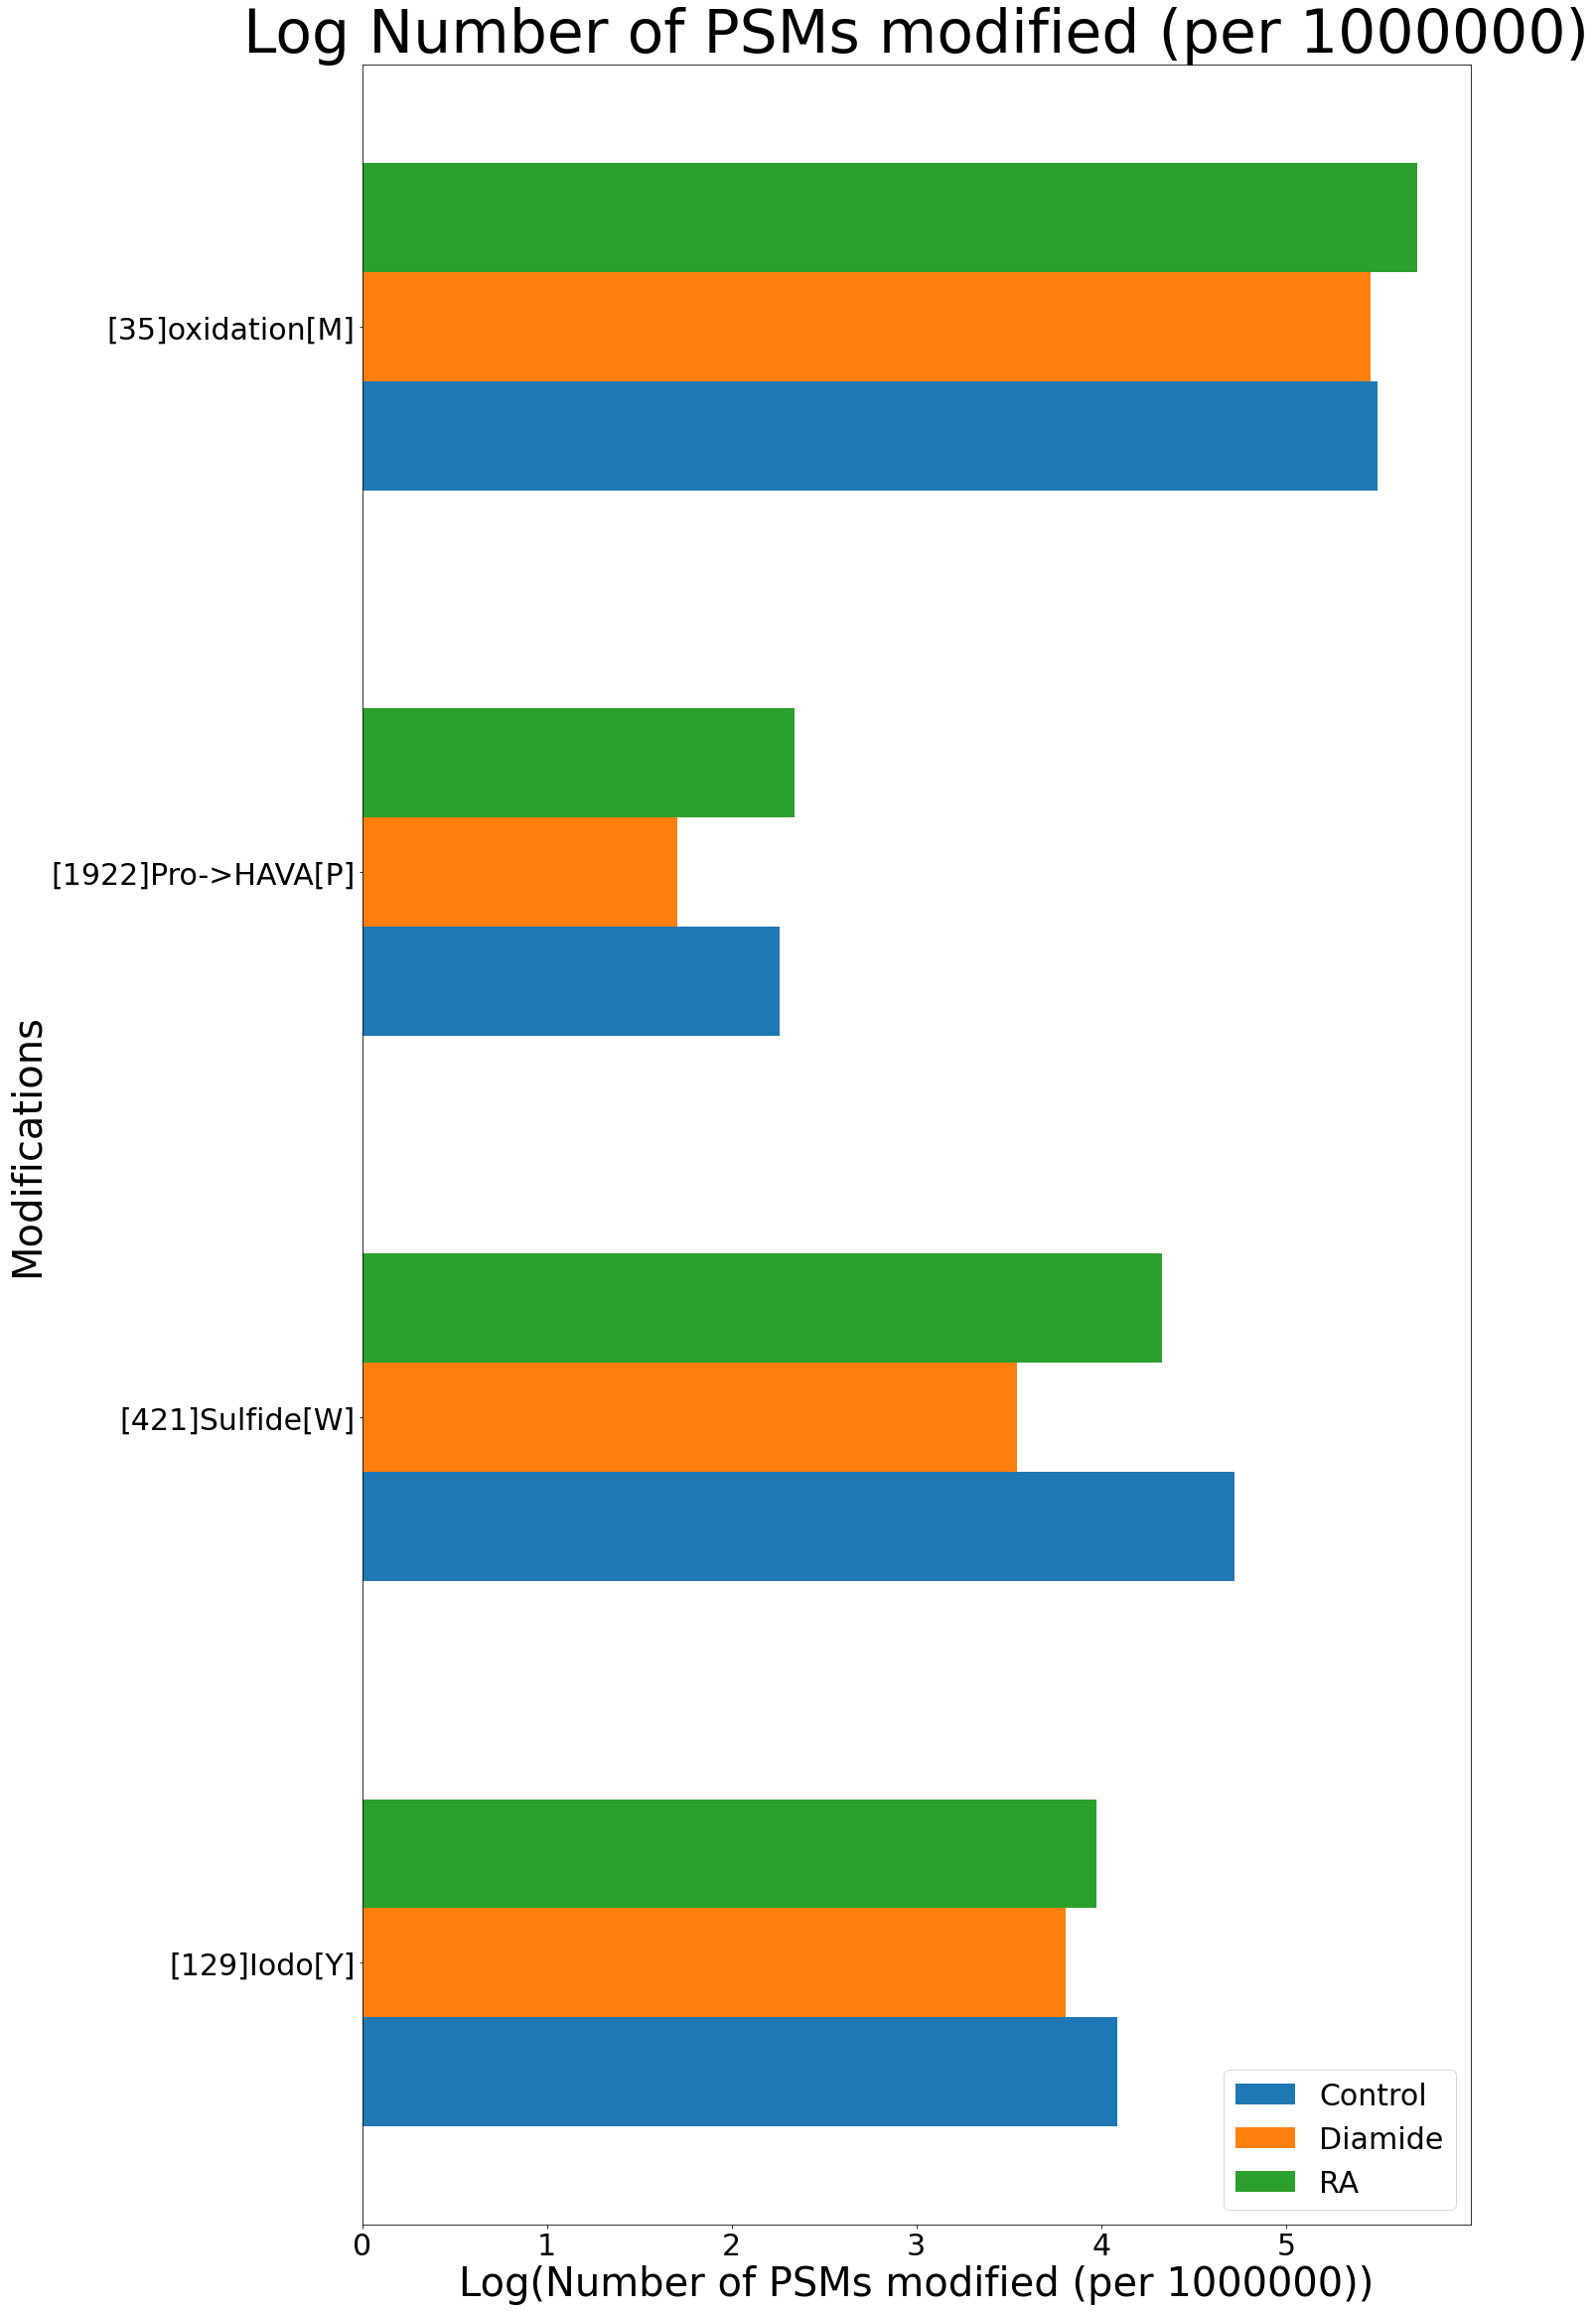

In [12]:
y = modr["Modification"]
xGlu = np.log10(modr['Ratios_Control']*1000000)
xstGal = np.log10(modr['Ratios_Diamide']*1000000)
xltGal = np.log10(modr['Ratios_RA']*1000000)
y_axis = np.arange(len(y))
plt.figure(figsize=(20,40))
plt.barh(y_axis - 0.2, xGlu, 0.2, label = 'Control')
plt.barh(y_axis, xstGal, 0.2, label = 'Diamide')
plt.barh(y_axis + 0.2, xltGal, 0.2, label = 'RA')

plt.yticks(y_axis, y)
plt.ylabel("Modifications", fontsize = 40)
plt.xlabel("Log(Number of PSMs modified (per 1000000))", fontsize = 40)
plt.title("Log Number of PSMs modified (per 1000000)", fontsize = 60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)
plt.show()

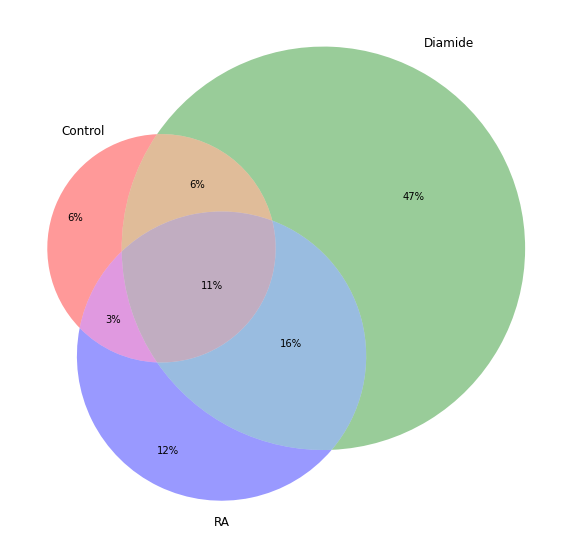

In [13]:
OA.condition_venn([Controlrep,Diamiderep,RArep], ["Control", "Diamide", "RA"])

In [14]:
RPMControl = OA.relative_PSM_modification(Controlrep)
RPMDiamide = OA.relative_PSM_modification(Diamiderep)
RPMRA = OA.relative_PSM_modification(RArep)

In [15]:
RPM = pd.merge(RPMControl, RPMDiamide, on="Amino acid", suffixes=('_Control','_Diamide'))
RPM = pd.merge(RPM, RPMRA, on="Amino acid")
RPM = RPM.rename(columns={"Relative level of PSMs containing unmodified residue" : "Relative level of PSMs containing unmodified residue_RA"})
RPM

,Amino acid,Relative level of PSMs containing unmodified residue_Control,Relative level of PSMs containing unmodified residue_Diamide,Relative level of PSMs containing unmodified residue_RA
0,A,1.000000,1.000000,1.000000
1,R,1.000000,0.999688,0.999393
2,N,0.988495,0.987143,0.991101
3,D,0.998802,0.999134,0.998924
4,C,0.052553,0.049373,0.024545
5,Q,0.998569,0.998250,0.997059
6,E,1.000000,0.998543,0.998141
7,G,1.000000,0.999201,1.000000
8,H,1.000000,0.994759,0.995795
9,I,1.000000,0.999077,1.000000


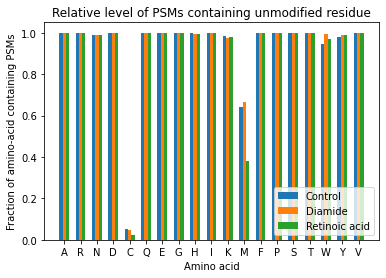

In [16]:
x = RPM["Amino acid"]
xGlu = RPM["Relative level of PSMs containing unmodified residue_Control"]
xst = RPM['Relative level of PSMs containing unmodified residue_Diamide']
xlt = RPM['Relative level of PSMs containing unmodified residue_RA']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xGlu, 0.2, label = 'Control')
plt.bar(x_axis, xst, 0.2, label = 'Diamide')
plt.bar(x_axis + 0.2, xlt, 0.2, label = 'Retinoic acid')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (20,20)
plt.legend(loc="lower right")
plt.show()

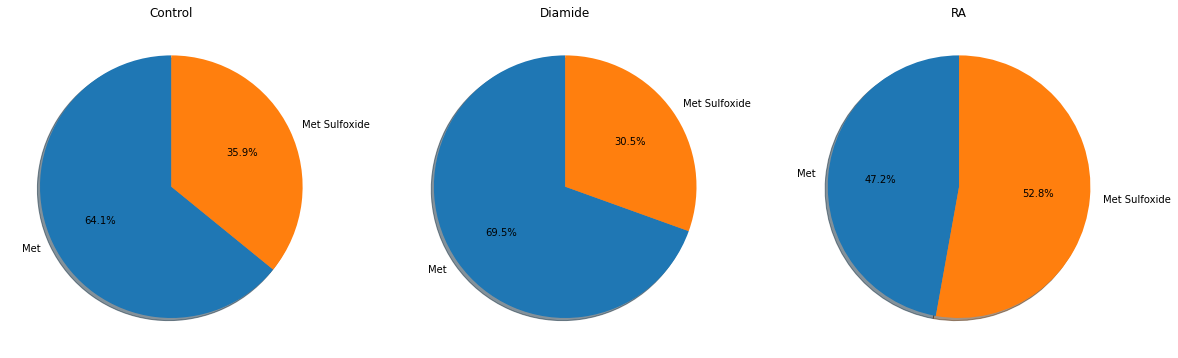

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.methionine_overview(Controlrep, ax1)
OA.methionine_overview(Diamiderep, ax2)
OA.methionine_overview(RArep, ax3)
plt.title("Methionine containing peptides")
ax1.set_title("Control")
ax2.set_title("Diamide")
ax3.set_title("RA")
plt.show()

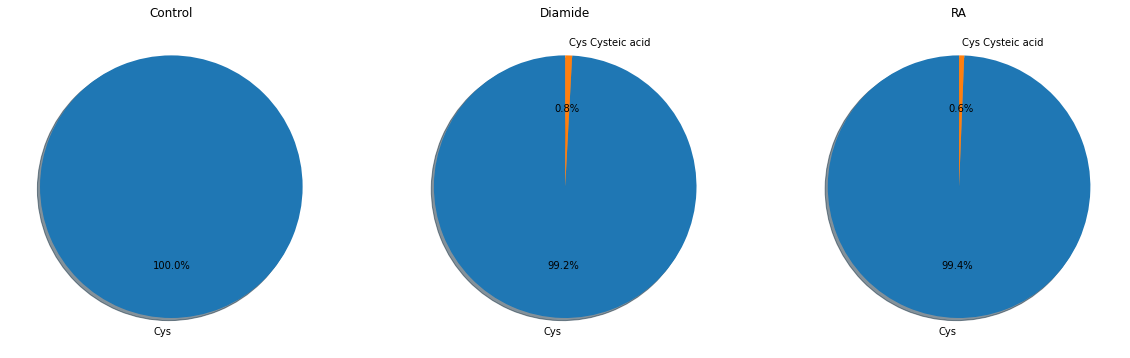

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.cysteine_overview(Controlrep, ax1)
OA.cysteine_overview(Diamiderep, ax2)
OA.cysteine_overview(RArep, ax3)
plt.title("cysteine containing peptides")
ax1.set_title("Control")
ax2.set_title("Diamide")
ax3.set_title("RA")
plt.show()

In [ ]:
os.chdir("/home/robbe/ionbot/differentially_oxidized_psms")

In [22]:
diffox, statement = OA.differentially_oxidized_psms(RArep, Controlrep)
with open("diffoxPXD014381.txt", "w") as f:
    for i in diffox:
        f.write(i)
        f.write("\n")
f.close()